# Data Modeling - Discount offer type

This notebook uses the datasets cleaned from the Data Wrangling step to perform predictive data modeling. The goal is to predict whether a Reward program user would complete a Discount offer. 

### Evaluation Metrics

For this type of classification model, we do not need to concern about **False Positives (Type 1 error)** (users we predict as responding yes to offer but actually would respond no) as it is okay to send offers to more people in a promotion, as the company has much to gain when users complete offers and make purchases. 

We would, however, want to minimize **False Negatives (Type 2 error)** (users who are predicted as responding no to the offer but actually would complete the offers). We would definitely not want to exclude the offer from those who would complete it and make purchases as that would mean loss of sure revenue. 

In order to minimize False Negatives, we should select a model that has high Recall score, meaning that most of the yes responses are correctly recognized (low False Negatives) but there might be a lot of false Yes responses.

### Import data and libraries

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import auc
from sklearn.metrics import plot_confusion_matrix

# Import models
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, GridSearchCV

# Import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, plot_roc_curve, plot_precision_recall_curve, precision_recall_curve, average_precision_score

In [2]:
# read in the csv files
offer_response = pd.read_csv('data/offer_response.csv')
user = pd.read_csv('data/profile_cleaned.csv')

In [3]:
# Merge profile and number of offers completed
df = pd.merge(offer_response, 
             user, 
             how='left', 
             on=['person']).dropna().replace({True:1,False:0}).drop(columns=['person'])

In [4]:
discount = df[df.offer_type=='discount']

In [5]:
# Convert categorical variables into dummy variables
clean_discount = pd.get_dummies(discount, columns=['gender']).drop_duplicates().drop(columns=['offer_type'])

### Class Imbalance

In [27]:
print('Percentage of Yes responses:')
print('%.2f' % (clean_discount[clean_discount.completed_offer==1].shape[0]/clean_discount.shape[0]*100))
print('Percentage of No responses:')
print('%.2f' % (clean_discount[clean_discount.completed_offer==0].shape[0]/clean_discount.shape[0]*100))


Percentage of Yes responses:
72.79
Percentage of No responses:
27.21


We have 3 times as many Yes responses compared to No responses. This is class imbalance and we will see a high False Positives in the results of the model

In [6]:
# Split features and dependent variable into training and test sets
y = clean_discount['completed_offer']
X = clean_discount.drop(['completed_offer'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 8228 samples.
Testing set has 2058 samples.


In [7]:
# feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
# Print evaluation metrics for a model (source: Udacity)
def print_metrics(y_true, preds, model_name=None):
    '''
    INPUT:
    y_true - the y values that are actually true in the dataset (numpy array or pandas series)
    preds - the predictions for those values from some model (numpy array or pandas series)
    model_name - (str - optional) a name associated with the model if you would like to add it to the print statements 
    
    OUTPUT:
    None - prints the accuracy, precision, recall, and F1 score
    '''
    if model_name == None:
        print('Accuracy score: ', format(accuracy_score(y_true, preds)))
        print('Precision score: ', format(precision_score(y_true, preds)))
        print('Recall score: ', format(recall_score(y_true, preds)))
        print('F1 score: ', format(fbeta_score(y_true, preds, beta=1)))
        print('\n\n')
    
    else:
        print('Accuracy score for ' + model_name + ' :' , format(accuracy_score(y_true, preds)))
        print('Precision score ' + model_name + ' :', format(precision_score(y_true, preds)))
        print('Recall score ' + model_name + ' :', format(recall_score(y_true, preds)))
        print('F1 score ' + model_name + ' :', format(fbeta_score(y_true, preds,beta=1)))
        print('\n\n')

### Base Model: Logistic Regression

Accuracy score for Logistics Regression : 0.7215743440233237
Precision score Logistics Regression : 0.7214634146341463
Recall score Logistics Regression : 0.9986495611073599
F1 score Logistics Regression : 0.8377230246389126



Confusion matrix, without normalization
[[   6  571]
 [   2 1479]]
Normalized confusion matrix
[[0.01 0.99]
 [0.   1.  ]]


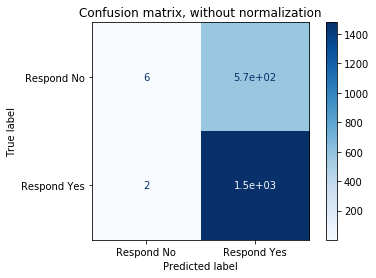

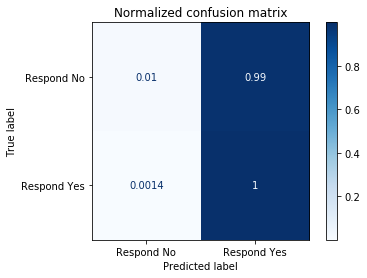

In [13]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train,y_train)
y_pred = log_reg.predict(X_test)

# Print the scores
print_metrics(y_test, y_pred,'Logistics Regression')

class_names = ['Respond No', 'Respond Yes']
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(log_reg, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

The Logistic Model has a much higher Recall than Precision, which is what we would want in our final model. The Recall score for the model is 0.99, and we'll use this score to compare this model to the next models.

### SVM Model

In [28]:
# Initiate and fit SVC model
svc = SVC(random_state=42)
svc.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

Accuracy score for SVC : 0.7376093294460642
Precision score SVC : 0.7384693360364927
Recall score SVC : 0.9837947332883187
F1 score SVC : 0.8436595251881877




Confusion matrix, without normalization
[[  61  516]
 [  24 1457]]
Normalized confusion matrix
[[0.11 0.89]
 [0.02 0.98]]


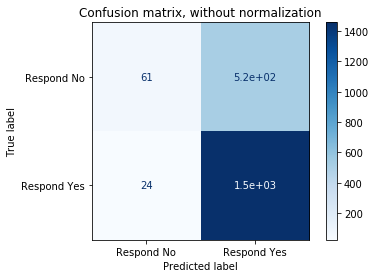

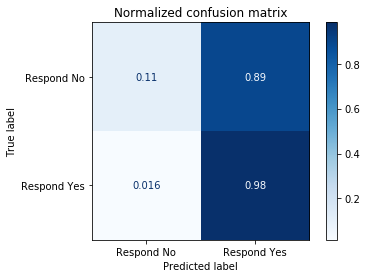

In [29]:
y_pred = svc.predict(X_test)

# Print the scores
print_metrics(y_test,y_pred,'SVC')
print()

class_names = ['Respond No', 'Respond Yes']
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(svc, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

SVC Model has a lower Recall score (0.84) than the Logistic Regression model's (0.99). Since we're optimizing for high Recall score, this means that Logistic model would be a better option than a basic SVC model.

### Ensemble Models

In [33]:
# Initiate ensemble models
rf_mod = RandomForestClassifier()
ada_mod = AdaBoostClassifier()
gb_mod = GradientBoostingClassifier()

In [34]:
# Fit models
rf_mod.fit(X_train, y_train)
ada_mod.fit(X_train, y_train)
gb_mod.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [35]:
# Predict responses
rf_y_pred = rf_mod.predict(X_test)
ada_y_pred = ada_mod.predict(X_test)
gb_y_pred = gb_mod.predict(X_test)

In [36]:
# Print the scores
print_metrics(y_test, rf_y_pred, 'Random Forest')
print_metrics(y_test, ada_y_pred, 'AdaBoost')
print_metrics(y_test, gb_y_pred, 'Gradien Boost')

Accuracy score for Random Forest : 0.6423712342079689
Precision score Random Forest : 0.718475073313783
Recall score Random Forest : 0.8271438217420661
F1 score Random Forest : 0.7689893283113622



Accuracy score for AdaBoost : 0.749271137026239
Precision score AdaBoost : 0.7559681697612732
Recall score AdaBoost : 0.962187711006077
F1 score AdaBoost : 0.8467023172905526



Accuracy score for Gradien Boost : 0.7517006802721088
Precision score Gradien Boost : 0.7523413111342352
Recall score Gradien Boost : 0.9763673193787981
F1 score Gradien Boost : 0.8498383779018513





### Model Comparison

Among all models we're built for this dataset, AdaBoost and Gradient Boost models give us the highest F1-score (0.85), followed by Logistic Regression and SVC (F-beta score is takes both precision and recall into consideration). Unlike the BOGO offer type, for Discount offer type, Logistic Regression model has the highest Recall score (1), followed by SVC (0.98).

|           | Logistic Regression | SVC  | Random Forest | AdaBoost | Gradient Boost |
|-----------|---------------------|------|---------------|----------|----------------|
| Accuracy  | 0.72                | 0.74 | 0.64          | 0.75     | 0.75           |
| Precision | 0.72                | 0.74 | 0.72          | 0.76     | 0.75           |
| Recall    | 1                   | 0.98 | 0.83          | 0.96     | 0.97           |
| F1        | 0.84                | 0.84 | 0.77          | 0.85     | 0.85           |

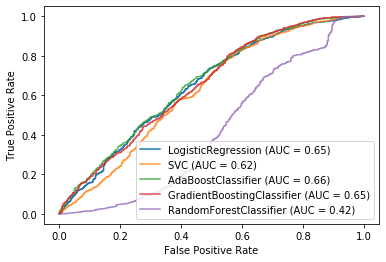

In [37]:
# Plot ROC curve
log_disp = plot_roc_curve(log_reg, X_test, y_test)
ax = plt.gca()
svc_disp = plot_roc_curve(svc, X_test, y_test, ax=ax, alpha=0.8)
ada_disp = plot_roc_curve(ada_mod, X_test, y_test, ax=ax, alpha=0.8)
gb_disp = plot_roc_curve(gb_mod, X_test, y_test, ax=ax, alpha=0.8)
rf_disp = plot_roc_curve(rf_mod, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

### Hyper-parameter tuning for SVC and Logistic Regression

#### Tune SVC

In [39]:
# Set the parameters by cross-validation
tuned_parameters = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']} 

print("# Tuning hyper-parameters for recall score")
print()

clf = GridSearchCV(
    SVC(), tuned_parameters, scoring='recall_macro')
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

# Tuning hyper-parameters for recall score

Best parameters set found on development set:

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

Grid scores on development set:

0.507 (+/-0.002) for {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.551 (+/-0.011) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.540 (+/-0.010) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.498 (+/-0.020) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.557 (+/-0.014) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.500 (+/-0.000) for

In [40]:
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print_metrics(y_true, y_pred)
print()

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

Accuracy score:  0.7308066083576288
Precision score:  0.7482592394215318
Recall score:  0.9432815665091154
F1 score:  0.8345280764635602






In [44]:
tuned_svc = SVC(C=100,gamma=0.1,kernel='rbf',random_state=42)
tuned_svc.fit(X_train, y_train)
tuned_svc_y_pred = tuned_svc.predict(X_test)
print_metrics(y_test, tuned_svc_y_pred, 'Optimized SVC')

Accuracy score for Optimized SVC : 0.7308066083576288
Precision score Optimized SVC : 0.7482592394215318
Recall score Optimized SVC : 0.9432815665091154
F1 score Optimized SVC : 0.8345280764635602





#### Tune Logistic Regression

In [45]:
# Set the parameters by cross-validation
tuned_parameters = {
 'max_iter':[100,110,120,130,140],
 'dual':[True,False]
 }

print("# Tuning hyper-parameters for recall score")
print()

print(LogisticRegression().get_params().keys())

clf = GridSearchCV(
    LogisticRegression(), tuned_parameters, scoring='recall_macro')
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print_metrics(y_true, y_pred)
print()

# Tuning hyper-parameters for recall score

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only dual=False, got dual=True

  FitFailedWarning)


Best parameters set found on development set:

{'dual': False, 'max_iter': 100}

Grid scores on development set:

nan (+/-nan) for {'dual': True, 'max_iter': 100}
nan (+/-nan) for {'dual': True, 'max_iter': 110}
nan (+/-nan) for {'dual': True, 'max_iter': 120}
nan (+/-nan) for {'dual': True, 'max_iter': 130}
nan (+/-nan) for {'dual': True, 'max_iter': 140}
0.505 (+/-0.004) for {'dual': False, 'max_iter': 100}
0.505 (+/-0.004) for {'dual': False, 'max_iter': 110}
0.505 (+/-0.004) for {'dual': False, 'max_iter': 120}
0.505 (+/-0.004) for {'dual': False, 'max_iter': 130}
0.505 (+/-0.004) for {'dual': False, 'max_iter': 140}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

Accuracy score:  0.7215743440233237
Precision score:  0.7214634146341463
Recall score:  0.9986495611073599
F1 score:  0.8377230246389126






In [46]:
tuned_lg = LogisticRegression(dual=False,max_iter=100,random_state=42)
tuned_lg.fit(X_train, y_train)
tuned_lg_y_pred = tuned_lg.predict(X_test)
print_metrics(y_test, tuned_lg_y_pred, 'Optimized Logistic Regression')

Accuracy score for Optimized Logistic Regression : 0.7215743440233237
Precision score Optimized Logistic Regression : 0.7214634146341463
Recall score Optimized Logistic Regression : 0.9986495611073599
F1 score Optimized Logistic Regression : 0.8377230246389126





**Compare the tuned models**

|           | Tuned SVC | Tuned Logistic Regression |
|-----------|-----------|---------------------------|
| Accuracy  | 0.72      | 0.72                      |
| Precision | 0.72      | 0.72                      |
| Recall    | 1         | 1                         |
| F1        | 0.83      | 0.83                      |

#### Plot ROC curves

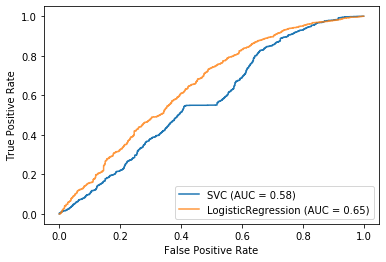

In [47]:
tuned_svc_disp = plot_roc_curve(tuned_svc, X_test, y_test)
ax = plt.gca()
tuned_lg_disp = plot_roc_curve(tuned_lg, X_test, y_test,ax=ax, alpha=0.8)
plt.show()